In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import pytz
import numpy as np
import matplotlib.dates as mdates
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import data from ENTSOE

Warning! The data of ENTSOE is actualised every day at 14:00 CEST. The server isn't available at this time +- 5 minutes!

https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show?name=&defaultValue=false&viewType=GRAPH&areaType=CTY&atch=false&datepicker-day-offset-select-dv-date-from_input=D&dateTime.dateTime=04.04.2024%2000:00|CET%7CDAYTIMERANGE&dateTime.endDateTime=04.04.2024%2000:00|CET%7CDAYTIMERANGE&area.values=CTY%7C10Y1001A1001A83F!CTY%7C10Y1001A1001A83F&productionType.values=B01&productionType.values=B02&productionType.values=B03&productionType.values=B04&productionType.values=B05&productionType.values=B06&productionType.values=B07&productionType.values=B08&productionType.values=B09&productionType.values=B10&productionType.values=B11&productionType.values=B12&productionType.values=B13&productionType.values=B14&productionType.values=B20&productionType.values=B15&productionType.values=B16&productionType.values=B17&productionType.values=B18&productionType.values=B19&dateTime.timezone=CET_CEST&dateTime.timezone_input=CET+(UTC+1)+/+CEST+(UTC+2)

In [4]:
# Get the current date
current_date = datetime.now()
# Format the date as dd.mm.yyyy
formatted_date_today = current_date.strftime("%d.%m.%Y")
# formatted_date_today = "03.04.2024"


# URL of the webpage containing the table
url = f"https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show?name=&defaultValue=false&viewType=TABLE&areaType=CTY&atch=false&datepicker-day-offset-select-dv-date-from_input=D&dateTime.dateTime={formatted_date_today}+00:00|CET|DAYTIMERANGE&dateTime.endDateTime={formatted_date_today}+00:00|CET|DAYTIMERANGE&area.values=CTY|10Y1001A1001A83F!CTY|10Y1001A1001A83F&productionType.values=B01&productionType.values=B02&productionType.values=B03&productionType.values=B04&productionType.values=B05&productionType.values=B06&productionType.values=B07&productionType.values=B08&productionType.values=B09&productionType.values=B10&productionType.values=B11&productionType.values=B12&productionType.values=B13&productionType.values=B14&productionType.values=B20&productionType.values=B15&productionType.values=B16&productionType.values=B17&productionType.values=B18&productionType.values=B19&dateTime.timezone=CET_CEST&dateTime.timezone_input=CET+(UTC+1)+/+CEST+(UTC+2)"

# Send a GET request to fetch the webpage content
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Find all tables in the HTML
tables = soup.find_all('table')

# Iterate through each table to find the one containing "Biomass"
target_table = None
for table in tables:
    if "Biomass" in table.get_text():
        target_table = table
        break

if target_table:
    # Convert the HTML table to a pandas DataFrame
    df = pd.read_html(str(target_table))[0]
    # Replace "n/e" with NaN
    df.replace('-', np.nan, inplace=True)
    df.replace('n/e', np.nan, inplace=True)

    # Print the DataFrame
    # print(df)
    df.to_csv("../../data/carbon_footprint_data.csv", sep=';', header=True,index=False)
    
else:
    print("No table containing 'Biomass' found on the webpage.")

In [5]:
df = pd.read_csv("../../data/carbon_footprint_data.csv", sep=";",header=1)
df = df.iloc[3:]
# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)
columns_to_convert = [col for col in df.columns if col != 'MTU']
df[columns_to_convert] = df[columns_to_convert].astype(float)
df[['start', 'end']] = df['MTU'].str.split(' - ', expand=True)


# Get the current date and time in CET timezone
current_datetime_cet = datetime.now(pytz.timezone('Europe/Paris'))

# Extract the date part
current_date = current_datetime_cet.date()

# Convert the "start" column to datetime format with the current date
df['start_datetime'] = pd.to_datetime(current_date.strftime("%Y-%m-%d") + ' ' + df['start'])
df['start_datetime'] = df['start_datetime'].dt.tz_localize('Europe/Paris')

# Convert the datetime to Unix timestamp
df['start_unix_timestamp'] = df['start_datetime'].astype(int) / 10**9  # Convert nanoseconds to seconds

# Convert the "start" column to datetime format with the current date
df['end_datetime'] = pd.to_datetime(current_date.strftime("%Y-%m-%d") + ' ' + df['end'])
df['end_datetime'] = df['end_datetime'].dt.tz_localize('Europe/Paris')

# Convert the datetime to Unix timestamp
df['end_unix_timestamp'] = df['end_datetime'].astype(int) / 10**9  # Convert nanoseconds to seconds

df.to_csv("../../data/carbon_footprint_data.csv", sep=';', header=True,index=False)


In [8]:
columns = {
    'Biomass',
    'Fossil Brown coal/Lignite',
    'Fossil Coal-derived gas',
    'Fossil Gas',
    'Fossil Hard coal',
    'Fossil Oil',
    'Fossil Oil shale',
    'Fossil Peat',
    'Geothermal',
    'Hydro Pumped Storage',
    'Hydro Pumped Storage.1',
    'Hydro Run-of-river and poundage',
    'Hydro Water Reservoir',
    'Marine',
    'Nuclear',
    'Other',
    'Other renewable',
    'Solar',
    'Waste',
    'Wind Offshore',
    'Wind Onshore'
}
line_styles = ['-', '--', '-.', ':']

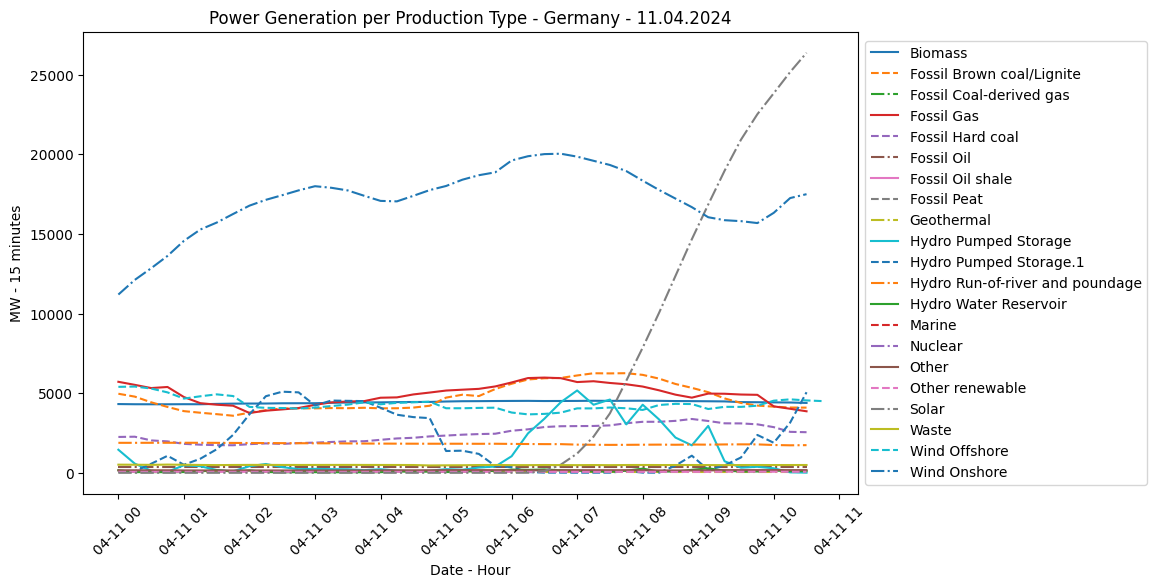

In [10]:
# Plotting
plt.figure(figsize=(10, 6))

for i, column in enumerate(sorted(columns)):
    plt.plot(df['start_datetime'], df[f'{column}'], label=f'{column}', linestyle=line_styles[i%3])
plt.xlabel('Date - Hour')
plt.ylabel('MW - 15 minutes')
plt.title(f'Power Generation per Production Type - Germany - {formatted_date_today}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.show()

# CO2 Äquivalente

https://www.umweltbundesamt.de/sites/default/files/medien/1410/publikationen/2023_05_23_climate_change_20-2023_strommix_bf.pdf

In [ ]:
#  CO2 Produktion in gr/kWh
# BITTE ZAHLEN NOCHMAL ÜBERPRÜFEN

co2_dict= {
    'Biomass': 230,
    'Fossil Brown coal/Lignite': 1137,
    'Fossil Coal-derived gas': 650,
    'Fossil Gas': 381,
    'Fossil Hard coal': 853,
    'Fossil Oil': 859,
    'Fossil Oil shale': 800,
    'Fossil Peat': 800,
    'Geothermal': 38,
    'Hydro Pumped Storage': 32,
    'Hydro Pumped Storage.1': 32,
    'Hydro Run-of-river and poundage': 32,
    'Hydro Water Reservoir': 32,
    'Marine': 24,
    'Nuclear': 11,
    'Other': 200,
    'Other renewable': 25,
    'Solar': 143,
    'Waste': 350,
    'Wind Offshore': 4,
    'Wind Onshore': 7
}


CO2 Äquivalente Tabelle berechnen

In [ ]:
# co2 dict ist in gr/kWh
# df[energy source] ist in MW pro viertelstunde
#  Umrechnung: df[energy_source]/4 -> MWh 
#  df[energy_source]/4*1000 -> kWh


for energy_source, co2_emission in co2_dict.items():
    df[f"{energy_source}_co2"] = df[energy_source]/4*1000 * co2_emission

df['totalEnergy_MWh'] = df[list(columns)].sum(axis=1)# still in MW pro 15 minutes
df['totalEnergy_MWh'] = df['totalEnergy_MWh']/4# now in MWh
columns_to_sum_co2 = [column + '_co2' for column in columns]
df['totalCO2_gr'] = df[columns_to_sum_co2].sum(axis=1)
df['emission_gr_kWh'] = round(df['totalCO2_gr'] / (df['totalEnergy_MWh']*1000),3) # gr / MWh*1000 -> gr/kWh

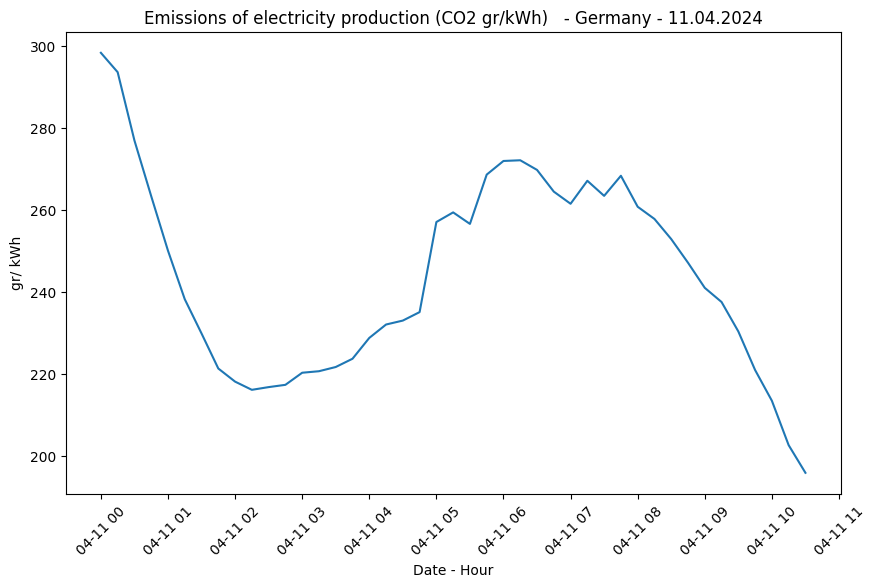

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))


plt.plot(df['start_datetime'], df["emission_gr_kWh"], label="emission_gr_kWh")
plt.xlabel('Date - Hour')
plt.ylabel('gr/ kWh')
plt.title(f'Emissions of electricity production (CO2 gr/kWh)   - Germany - {formatted_date_today}')

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.show()

In [ ]:
df.to_csv("../../data/carbon_footprint_data.csv", sep=';', header=True,index=False)